In [19]:
##
## Sobre el Orden
##
## ---------------------------
## Step 1: Ejecutando un árbol
## ---------------------------
##
## A tree with strong roots laughs at storms.
## --- Malay proverb
##

# Librerías necesarias
require("data.table")
require("rpart")
require("ggplot2")


Loading required package: ggplot2



In [18]:
install.packages("ggplot2")

Installing package into 'C:/Users/yvidal/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)

also installing the dependencies 'colorspace', 'farver', 'labeling', 'munsell', 'RColorBrewer', 'viridisLite', 'gtable', 'isoband', 'scales'




package 'colorspace' successfully unpacked and MD5 sums checked
package 'farver' successfully unpacked and MD5 sums checked
package 'labeling' successfully unpacked and MD5 sums checked
package 'munsell' successfully unpacked and MD5 sums checked
package 'RColorBrewer' successfully unpacked and MD5 sums checked
package 'viridisLite' successfully unpacked and MD5 sums checked
package 'gtable' successfully unpacked and MD5 sums checked
package 'isoband' successfully unpacked and MD5 sums checked
package 'scales' successfully unpacked and MD5 sums checked
package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yvidal\AppData\Local\Temp\RtmpS0xxJZ\downloaded_packages


In [8]:
# Poner la carpeta de la materia de SU computadora local
setwd("C:/YAGO/Maestría Ciencias de Datos/07-DMEYF/")
# Poner sus semillas
semillas <- c(444457,444583,444697,444743,444817)

In [9]:

# Cargamos el dataset
dataset <- fread("./datasets/competencia1_2022.csv")
dtrain <- dataset[foto_mes == 202101]


In [11]:
# Generamos el primer modelo
arbol <- rpart(formula =    "clase_ternaria ~ .",
                 data =      dtrain,
                 xval =      0,
                 cp =       -0.3,
                 minsplit =  0,
                 minbucket = 1,
                 maxdepth =  4)

View(arbol)

## Preguntas
## Usualmente se suele cortar las variables en 2 intervalos
## - ¿Se podría cortar en más intervalos?
## - ¿Cuál sería el costo?
## - ¿Se obtendrían mejores resultados?
##

n= 161342 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 161342 1514 CONTINUA (0.004115481 0.005268312 0.990616207)  
   2) ctrx_quarter< 13.5 8400  711 CONTINUA (0.034761905 0.049880952 0.915357143)  
     4) mcuentas_saldo< -1256.1 2928  416 CONTINUA (0.061816940 0.080259563 0.857923497)  
       8) cprestamos_personales< 1.5 2328  396 CONTINUA (0.074312715 0.095790378 0.829896907)  
        16) cdescubierto_preacordado< 0.5 321  116 CONTINUA (0.171339564 0.190031153 0.638629283) *
        17) cdescubierto_preacordado>=0.5 2007  280 CONTINUA (0.058794220 0.080717489 0.860488291) *
       9) cprestamos_personales>=1.5 600   20 CONTINUA (0.013333333 0.020000000 0.966666667)  
        18) Visa_status>=8 74    3 CONTINUA (0.013513514 0.027027027 0.959459459) *
        19) Visa_status< 8 526   17 CONTINUA (0.013307985 0.019011407 0.967680608) *
     5) mcuentas_saldo>=-1256.1 5472  295 CONTINUA (0.020285088 0.033625731 0.946089181)  
      10) mcaja_ahorro<

In [12]:
## ---------------------------
## Step 2: De árbol a tabla
## ---------------------------

# La siguiente función devuelve todas las hojas (nodos terminales) en una tabla
# para poder analizar mejor nuestro árbol.
tablahojas <- function(arbol, datos, target = "clase_ternaria") {
  # Tomamos la columna con el target
  target_vector <- datos[, get(target)]
  # Tomamos las clases de nuestro target
  classes <- unique(target_vector)
  # Tomamos las posicion de las hojas que aplican a los registro de nuestro ds
  row_leaf <- unique(arbol$where)
  leaves <- data.table(row_frame = row_leaf)
  setkey(leaves,row_frame)
  # Relacion target ~ hojas
  leaves_target <- dcast(
    data.table(
      target = target_vector,
      leaf = arbol$where),
    leaf ~ target, length,
    value.var = "target")
  setkey(leaves_target, leaf)
  # Juntamos todo
  leaves_target <- leaves_target[leaves, nomatch = 0]
  # Sumamos algunas columnas calculadas
  colnames(leaves_target[, classes, with = FALSE])[apply(
    leaves_target[, classes, with = FALSE], 1, which.max)]
  # Clase mayoritaria
  leaves_target[, y := colnames(
                    leaves_target[, classes, with = FALSE]
                  )[apply(leaves_target[, classes, with = FALSE],
                   1, which.max)]]
  # Cantidad de elementos de la hoja
  leaves_target[, TOTAL := unlist(Reduce(function(a, b) Map(`+`, a, b), .SD)),
                 .SDcols = classes]
  leaves_target
}

# Ejecutamos la función sobre nuestro modelo, con nuestros datos
hojas <- tablahojas(arbol, dtrain)
View(hojas)

## Preguntas
## - ¿Con qué criterio eligió la clase de cada hoja que determino la
##   clasificación de los registros?
## - ¿Cuántas hojas con BAJAS+2 hay?

leaf,BAJA+1,BAJA+2,CONTINUA,y,TOTAL
<int>,<int>,<int>,<int>,<chr>,<int>
5,55,61,205,CONTINUA,321
6,118,162,1727,CONTINUA,2007
8,1,2,71,CONTINUA,74
9,7,10,509,CONTINUA,526
12,16,40,378,CONTINUA,434
13,69,111,2757,CONTINUA,2937
15,1,0,0,BAJA+1,1
16,25,33,2042,CONTINUA,2100
20,4,3,4,CONTINUA,11


In [13]:
## ---------------------------
## Step 3: Calculando la ganancia de cada hoja
## ---------------------------

# Agregamos un nuevo campo de nombre ganancia
hojas[, ganancia := `BAJA+2` * 78000 - 2000 * (CONTINUA + `BAJA+1`)]
View(hojas)

## Pregunta
## - ¿Cuantás hojas que no son BAJA+2 tienen aún así ganancia positiva?

leaf,BAJA+1,BAJA+2,CONTINUA,y,TOTAL,ganancia
<int>,<int>,<int>,<int>,<chr>,<int>,<dbl>
5,55,61,205,CONTINUA,321,4238000
6,118,162,1727,CONTINUA,2007,8946000
8,1,2,71,CONTINUA,74,12000
9,7,10,509,CONTINUA,526,-252000
12,16,40,378,CONTINUA,434,2332000
13,69,111,2757,CONTINUA,2937,3006000
15,1,0,0,BAJA+1,1,-2000
16,25,33,2042,CONTINUA,2100,-1560000
20,4,3,4,CONTINUA,11,218000


In [14]:
## ---------------------------
## Step 4: Sumarizando el envío
## ---------------------------

View(hojas[ganancia > 0, .(
    ganancia = sum(ganancia),
    enviados = sum(TOTAL),
    sevan = sum(`BAJA+2`))])

# lift -> métrica que explica cuanto mejoraste con respecto al azar anterior. 
## Preguntas
## Si enviaramos todos los casos de las hojas con ganancia positiva
## - ¿Cuánta ganancia tendríamos?
## - ¿Cuánta personas estimularíamos?
## - ¿A cuántas personas acertaríamos?

ganancia,enviados,sevan
<dbl>,<int>,<int>
18912000,9904,484


In [15]:
## ---------------------------
## Step 5: Binarizando la salida (en tu cara RAE)
## ---------------------------

# Creamos un nuevo target binario
dtrain[, clase_binaria := ifelse(
                            clase_ternaria == "BAJA+2",
                                "evento",
                                "noevento"
                            )]
# Borramos el target viejo
dtrain[, clase_ternaria := NULL]

arbolbinario <- rpart("clase_binaria ~ .",
                 data =      dtrain,
                 xval =      0,
                 cp =       -0.3,
                 minsplit =  0,
                 minbucket = 5,
                 maxdepth =  4)
# Transformamos las hojas a una tabla
hojasbinario <- tablahojas(arbolbinario, dtrain, "clase_binaria")

# Y agregamos la ganancia de cada hoja
hojasbinario[, ganancia := evento * 78000 - 2000 * noevento]
View(hojasbinario)
# Por último sumarizamos
View(hojasbinario[ganancia > 0,
 .(ganancia = sum(ganancia), enviados = sum(TOTAL), sevan = sum(evento))])

## Pregunta
## - ¿Considera que la agrupación de clases fue positiva para la  ganancia?

leaf,evento,noevento,y,TOTAL,ganancia
<int>,<int>,<int>,<chr>,<int>,<dbl>
5,60,219,noevento,279,4242000
6,137,1402,noevento,1539,7882000
8,5,250,noevento,255,-110000
9,7,237,noevento,244,72000
12,18,121,noevento,139,1162000
13,69,1362,noevento,1431,2658000
15,29,566,noevento,595,1130000
16,35,1773,noevento,1808,-816000
20,3,4,noevento,7,226000


ganancia,enviados,sevan
<dbl>,<int>,<int>
20656000,9712,501


In [16]:
## ---------------------------
## Step 6: Salida probabilísticas
## ---------------------------

# Calculamos la probabilidad de evento en cada hoja
hojasbinario[, p_evento := evento / (evento + noevento)]

# Ordenamos de forma descendiente las probabilidades, ya que nos interesan
# ante todo las probabilidades más altas
hojasordenadas <- hojasbinario[order(-p_evento),]

# Calculamos la ganancia acumulada, desde con la probabilidad desde la primera
# fila con probabilidad más alta hasta la fila N, para cada fila.
hojasordenadas[, gan_acum := cumsum(ganancia)]

View(hojasordenadas)

# TAREAS:
# - Calculé la probabilidad de NO evento
# - Puede pasar que dos hojas tengan la misma probabilidad, escriba una query
#   que las agrupe.

## Preguntas
## - ¿Cómo ve la relación entre la probabilidad ordenada y la hojas con
##   ganancia?
## - ¿Cuál es la máxima ganancia posible es nuestro árbol?
## - ¿Cuál es el `punto de corte` que sugiere?
## - ¿Por qué es distinto al teórico?
## - ¿Es nuestro `punto de corte` es igual de útil?

leaf,evento,noevento,y,TOTAL,ganancia,p_evento,gan_acum
<int>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
20,3,4,noevento,7,226000,0.428571429,226000
5,60,219,noevento,279,4242000,0.215053763,4468000
27,5,22,noevento,27,346000,0.185185185,4814000
12,18,121,noevento,139,1162000,0.129496403,5976000
6,137,1402,noevento,1539,7882000,0.089018843,13858000
15,29,566,noevento,595,1130000,0.048739496,14988000
13,69,1362,noevento,1431,2658000,0.048218029,17646000
21,173,5278,noevento,5451,2938000,0.031737296,20584000
9,7,237,noevento,244,72000,0.028688525,20656000


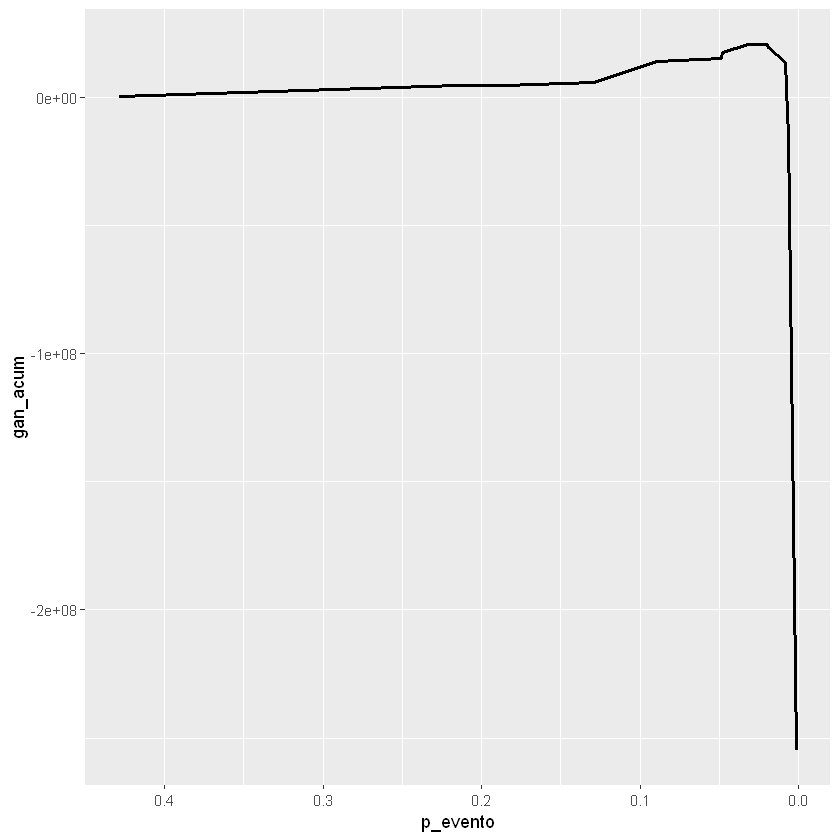

In [20]:
## ---------------------------
## Step 7: Graficando la ganancia
## ---------------------------

ggplot(hojasordenadas, aes(x = p_evento ,y = gan_acum)) +
     scale_x_reverse() +
     geom_line(size = 1)

## Pregunta
## ¿Cómo interpretamos este gráfico?

In [21]:
## ---------------------------
## Step 8: No todo es plata en la vida
## ---------------------------

## NOTA:
## Existen más formas de medir la calidad del modelo a través de las
## probabilidades que nos entrega. A nivel global podemos usar `AUC`: área bajo
## la curva ROC:https://en.wikipedia.org/wiki/Receiver_operating_characteristic
## que nos muestra el comportamiento global de la performance del modelo.
##
## Para la **curva ROC** vamos a necesitar construir una Matriz de confusión
## https://en.wikipedia.org/wiki/Confusion_matrix#Table_of_confusion por cada
## punto de corte posible.

# Vamos a sumar las variables `tp`, `tn`, `fp` y `fn`
hojasordenadas[, c("evento_acum","noevento_acum") :=
                  list(cumsum(evento),cumsum(noevento))]
total_evento <- hojasordenadas[, sum(evento)]
total_noevento <- hojasordenadas[, sum(noevento)]
hojasordenadas[, c("evento_restantes", "noevento_restantes") :=
            list(total_evento - evento_acum, total_noevento - noevento_acum)]

hojasordenadas[, tp := evento_acum]
hojasordenadas[, tn := noevento_restantes]
hojasordenadas[, fp := noevento_acum]
hojasordenadas[, fn := evento_restantes]

# Para validar los cálculos anteriores vamos a visualizar solo los campos
# importantes
View(hojasordenadas[, .(p_evento, evento, noevento, tp, tn, fp, fn)])

p_evento,evento,noevento,tp,tn,fp,fn
<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
0.428571429,3,4,3,160488,4,847
0.215053763,60,219,63,160269,223,787
0.185185185,5,22,68,160247,245,782
0.129496403,18,121,86,160126,366,764
0.089018843,137,1402,223,158724,1768,627
0.048739496,29,566,252,158158,2334,598
0.048218029,69,1362,321,156796,3696,529
0.031737296,173,5278,494,151518,8974,356
0.028688525,7,237,501,151281,9211,349


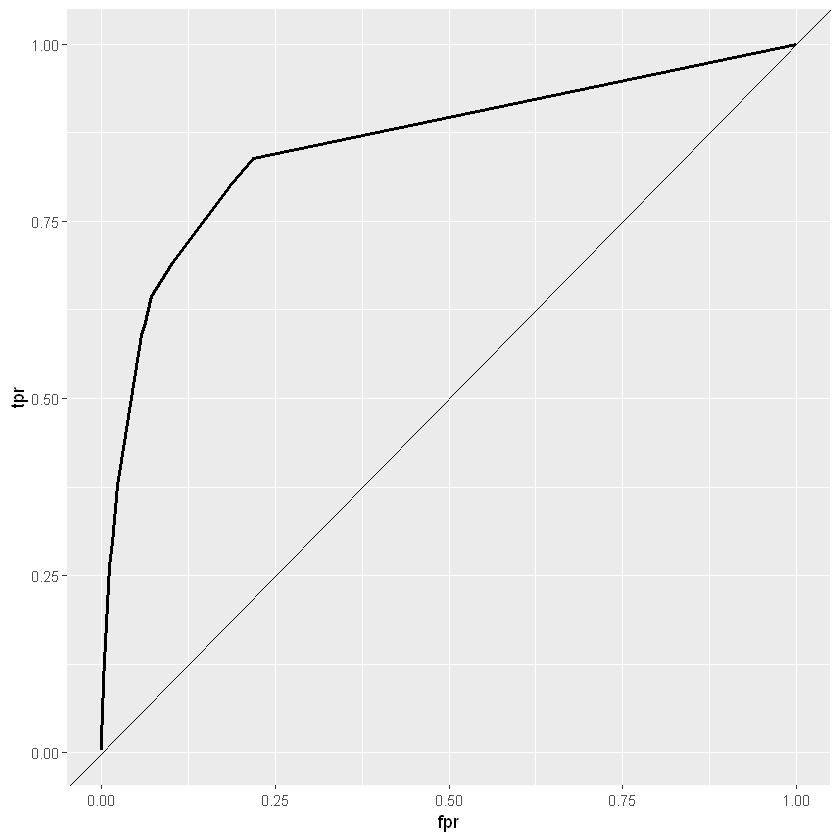

In [22]:
## ---------------------------
## Step 9: Armando nuestra curva ROC
## ---------------------------

# Calculamos las variables necesarios para la curva ROC
hojasordenadas[, tpr := (tp / (tp + fn))]
hojasordenadas[, fpr := (fp / (fp + tn))]

# La graficamos
ggplot(hojasordenadas, aes(x = fpr, y = tpr)) +
  # Agregamos la función identidad
  geom_abline(intercept = 0, slope = 1) +
  geom_line(lwd = 1)

## Pregunta
## ¿Qué representa la curva ROC?

In [25]:
## ---------------------------
## Step 10: Calculando el área bajo la curva
## ---------------------------

## NOTA: Como es muy complejo reflejar en palabras una curva, se suele calcular
## el área bajo su curva (auc) y reflejar ese valor como métrica de la
## calidad del modelo.

# Calculamos su área, necesita instalar el siguiente paquete
# install.packages("geometry")
require("geometry")

x <- c(hojasordenadas$fpr,1)
y <- c(hojasordenadas$tpr, 0)
# El valor de la auc
View(polyarea(x, y))


## Preguntas
## -¿AUC es una métrica global o local?
## -¿Pueden dos curvas distintas tener un mismo valor de AUC?

Loading required package: geometry



[1] 0.8574409

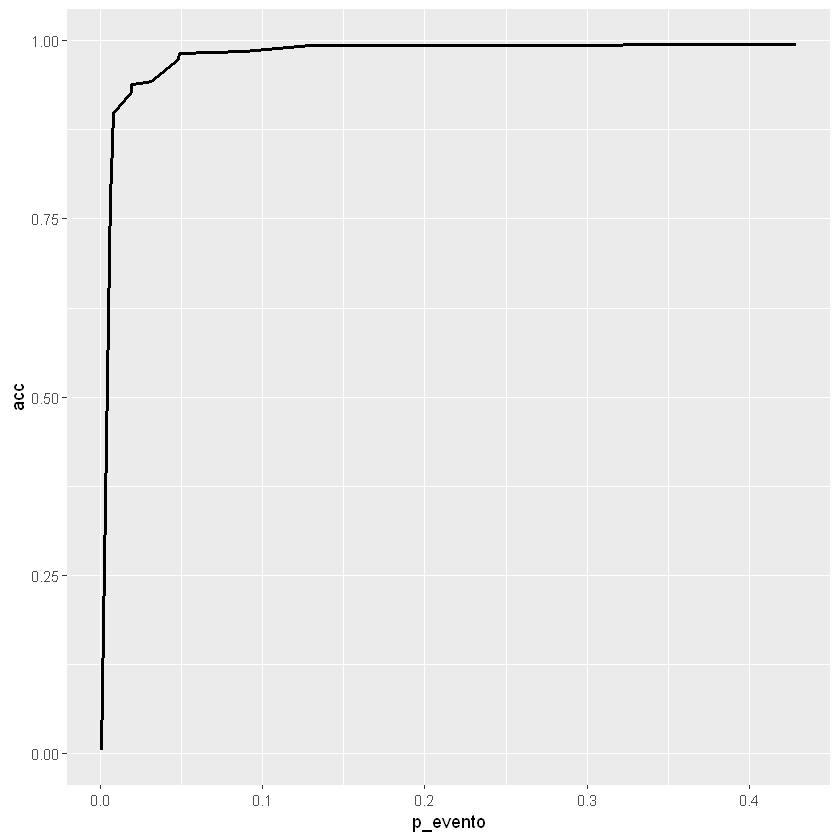

In [28]:
## ---------------------------
## Step 11: No limitarnos a la ROC
## ---------------------------

# Podemos construir una curva para el accuraccy
hojasordenadas[, acc := ((tp + tn) / (tp + tn + fp + fn))]

# Y graficarla
ggplot(hojasordenadas, aes(x = p_evento, y = acc)) +
  geom_line(lwd = 1)

## Preguntas
## - ¿Se ajusta esta curva a nuestra necesidad de negocio?
## -¿Cuál es el threshold optimo según la curva de accuracy?
## - Si hubiéramos elegido nuestro modelo usando el accuracy, ¿Cuanta plata
##   hubiera ganado o perdido la empresa?
## - ¿Es necesario que la salida del modelo sea un probabilidad para aplicar
##   estos conceptos?

## TAREA:
## - Construya la curva correspondiente al F1 Score.
## - La métrica F1, es criticado por dar un mismo peso a recall y al precision.
##   Por esto mismo, a alguien se le ocurrió el F-Beta. Construya esta última
##   para varios Betas.
## - ¿Hay algún Beta que tenga un **punto de corte** similar al nuestro?

In [ ]:
#TAREA

## CONSTRUCCIÓN DEL F1 B SCORE



In [31]:
##
## Sobre el Azar
##
## ---------------------------
## Step 1: El simple y viejo Train / Test
## ---------------------------
##
## If you torture the data long enough, it will confess.
## --- Ronald Coase
##

# Limpiamos el entorno
rm(list = ls())
gc(verbose = FALSE)

# Librerías necesarias
require("data.table")
require("rpart")
require("ROCR")
require("ggplot2")


# Poner la carpeta de la materia de SU computadora local
setwd("C:/YAGO/Maestría Ciencias de Datos/07-DMEYF/")
# Poner sus semillas
semillas <- c(444457,444583,444697,444743,444817)

# Cargamos el dataset
dataset <- fread("./datasets/competencia1_2022.csv")

# Nos quedamos solo con el 202101
dataset <- dataset[foto_mes == 202101]
# Creamos una clase binaria
dataset[, clase_binaria := ifelse(
                            clase_ternaria == "BAJA+2",
                                "evento",
                                "noevento"
                            )]
# Borramos el target viejo
dataset[, clase_ternaria := NULL]

# Seteamos nuestra primera semilla
set.seed(semillas[1])

# Particionamos de forma estratificada
in_training <- caret::createDataPartition(dataset$clase_binaria,
                     p = 0.70, list = FALSE)
dtrain  <-  dataset[in_training, ]
dtest   <-  dataset[-in_training, ]

## Preguntas
## - ¿Por qué separamos en train/test?
## - Son números aleatorios los que nos dan las computadoras
## - ¿Por qué usamos semillas?
## - ¿Qué es una partición estratificada?

## TAREA:
## - Comparar la distribución del target de una partición estratificada en
##   nuestro dataset con una que no la sea.
## - ¿Tiene realemente alguna ventaja la partición estratificada ?

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,964480,51.6,2108187,112.6,2108187,112.6
Vcells,1932595,14.8,117634752,897.5,173749286,1325.7


Loading required package: ROCR



In [34]:
## ---------------------------
## Step 2: Armando el primer modelo particionado
## ---------------------------

# Medimos cuanto tarda nuestro modelo en ajustar
start_time <- Sys.time()
modelo <- rpart(clase_binaria ~ .,
                data = dtrain,
                xval = 0,
                cp = 0,
                minsplit = 20,
                minbucket = 1,
                maxdepth = 5)
print(Sys.time() - start_time)

pred_training <- predict(modelo, dtrain, type = "prob")
pred_testing <- predict(modelo, dtest, type = "prob")


## Preguntas:
## - ¿Qué tan importante mirar las métricas de train?

## ---------------------------
## Step 3: Mirando la ganancia
## ---------------------------

# Armamos una función que nos calcule la ganancia, usando el punto de corte de
# 0.025
ganancia <- function(probabilidades, clase) {
  return(sum(
    (probabilidades >= 0.025) * ifelse(clase == "evento", 78000, -2000))
  )
}

# La ganancia en testing NORMALIZADA
print(ganancia(pred_testing[, "evento"], dtest$clase_binaria) / 0.3)

## Activida:
## Comparta en Zulip el número que le dio de ganancia y cuando error estima que
## puede haber con el resto de sus compañeros
## Ejemplo: 18000000, 1000000

Time difference of 3.826505 secs
[1] 16400000


In [38]:
## ---------------------------
## Step 4: Probando más muchas más semillas
## ---------------------------

# Almacenaremos los resultados en una tabla
resultados_n_gan <- c()

# Calcule en función del tiempo de ejecución anterior, cuantos árboles puede
# hacer en 5 minutos y ponga ese número en la siguiente variable
n <- 65

set.seed(semillas[1])
t0 <- Sys.time()
for (i in 1:n) {

    in_training <- caret::createDataPartition(dataset[, get("clase_binaria")],
                            p = 0.70, list = FALSE)
    dtrain  <-  dataset[in_training, ]
    dtest   <-  dataset[-in_training, ]

    modelo <- rpart(clase_binaria ~ .,
                    data = dtrain,
                    xval = 0,
                    cp = 0,
                    minsplit = 20,
                    minbucket = 1,
                    maxdepth = 5)

    pred_testing <- predict(modelo, dtest, type = "prob")

    gan <- ganancia(pred_testing[, "evento"], dtest$clase_binaria) / 0.3

    resultados_n_gan <- c(resultados_n_gan, gan)
}
print(Sys.time() - t0)

## Preguntas:
## ¿Cree que puede cambiar mucho la ganancia en **test** para dos semillas
## distintas?

Time difference of 4.957838 mins


[1] 15200000
[1] 19092000
[1] 17146400


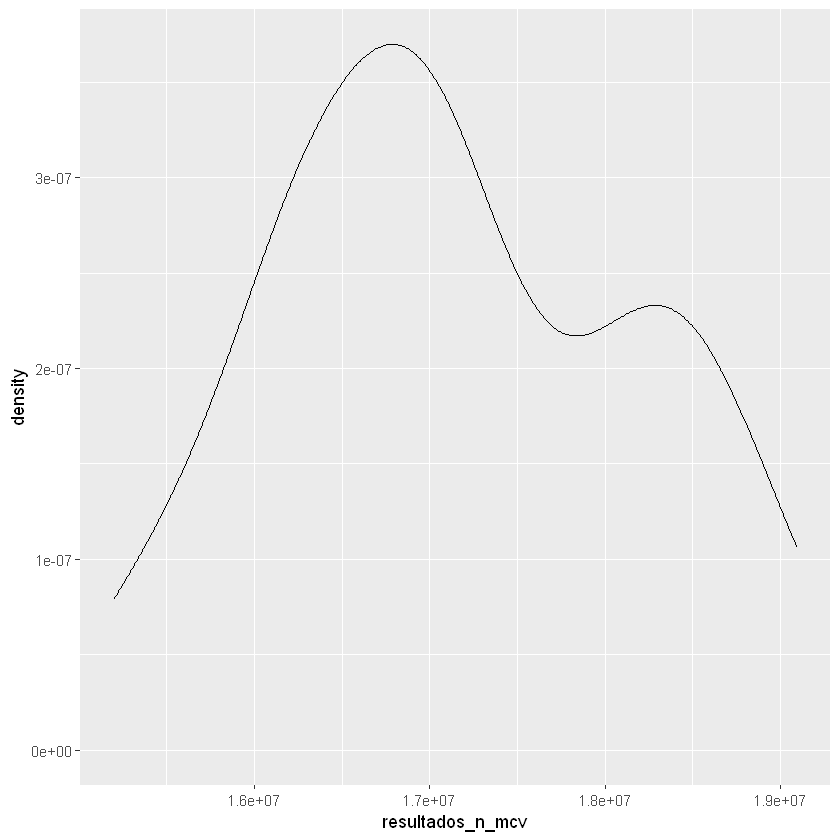

In [39]:
cantidad_arboles <- 5

resultados_n_mcv <- c()
set.seed(semillas[1])
for (i in 1:50) {
    resultados_n_mcv <- c(resultados_n_mcv,
            mean(resultados_n_gan[sample(n, cantidad_arboles)]))
}

# La menor ganancia conseguida en test
print(min(resultados_n_mcv))

# La mayor ganancia
print(max(resultados_n_mcv))

# La media de la ganancia
print(mean(resultados_n_mcv))

# Veamos la dispersión de la ganancia
ggplot() + aes(resultados_n_mcv) + geom_density()

## NOTA: Esta técnica es conocida como Montecarlo Cross Validation
##
## Preguntas
## - ¿Qué efecto observa cuando se toma como medición el promedio de 5 árboles?
## - ¿Desapareció el error?
## - ¿Si se hubieran tomado más valores que efectos esperaría?
## - ¿Que ventaja y desventaja ve en esta técnica comparada al Cross Validation?